In [1]:
from google.colab import drive
drive.mount('/content/drive')



import os

# Change Directory
os.chdir('/content/drive/MyDrive/239AS_T99_RL_Agent/gym-t99')

Mounted at /content/drive


In [2]:
import os
import sys

# list directories where packages are stored
# note that the parent directory of te repo is added automatically
GYM_FOLDER = "gym-t99"

# get this notebook's current working directory
nb_cwd = os.getcwd()
# get name of its parent directory
nb_parent = os.path.dirname(nb_cwd)
# add packages to path
sys.path.insert(len(sys.path), nb_parent)
sys.path.insert(len(sys.path), os.path.join(nb_parent, GYM_FOLDER))

In [3]:
!pip install pygame

     |████████████████████████████████| 11.8MB 5.4MB/s 


In [4]:
import gym
registered = gym.envs.registration.registry.env_specs.copy()

import gym_t99
import t_net

pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
import imp

# this code removes environment from gym's registry
env_dict = gym.envs.registration.registry.env_specs.copy()
for env in env_dict:
    if env not in registered:
        print("Remove {} from registry".format(env))
        del gym.envs.registration.registry.env_specs[env]

imp.reload(gym_t99)

Remove basic-v0 from registry
Remove t99-v0 from registry
Remove t99sc-v0 from registry


<module 'gym_t99' from '/content/drive/My Drive/239AS_T99_RL_Agent/gym-t99/gym_t99/__init__.py'>

In [6]:
# import matplotlib
import matplotlib as plt
# configure matplotlib
%matplotlib inline

import numpy as np
from copy import deepcopy

# import torch
import torch
from torch import nn

# configure torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# a simple random agent to play aginst and test
class RandomEnemySC:    
    # this interface needs to be supported for any agent
    def action(self, observation):
        return np.random.choice(observation)

In [8]:
custom_gym = gym.make('gym_t99:t99sc-v0', num_players = 1, enemy=RandomEnemySC())

In [9]:
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()

        self.layer1 = nn.Sequential(nn.Linear(4, 64), nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.Linear(64, 1))

        self._create_weights()

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.to(device)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x

In [10]:
def number_of_holes(board):
    '''Number of holes in the board (empty sqquare with at least one block above it)'''
    holes = 0

    for col in zip(*board):
        i = 0
        while i < board.shape[0] and col[i] == 0:
            i += 1
        holes += len([x for x in col[i+1:] if x == 0])

    return holes


def bumpiness(board):
    '''Sum of the differences of heights between pair of columns'''
    total_bumpiness = 0
    max_bumpiness = 0
    min_ys = []

    for col in zip(*board):
        i = 0
        while i < board.shape[0] and col[i] == 0:
            i += 1
        min_ys.append(i)

    for i in range(len(min_ys) - 1):
        bumpiness = abs(min_ys[i] - min_ys[i+1])
        max_bumpiness = max(bumpiness, max_bumpiness)
        total_bumpiness += abs(min_ys[i] - min_ys[i+1])

    return total_bumpiness, max_bumpiness


def height(board):
    '''Sum and maximum height of the board'''
    sum_height = 0
    max_height = 0
    min_height = board.shape[0]

    for col in zip(*board):
        i = 0
        while i < board.shape[0] and col[i] == 0:
            i += 1

        height = board.shape[0] - i
        sum_height += height
        if height > max_height:
            max_height = height
        elif height < min_height:
            min_height = height

    return sum_height, max_height, min_height


In [11]:
def calculate_features(player):
    num_rows = player.board.shape[0]
    num_cols = player.board.shape[1]
    board = player.board[5:num_rows-3, 3:num_cols-3]
    lines = player.num_lines_cleared
    holes = number_of_holes(board)
    total_bumpiness, max_bumpiness = bumpiness(board)
    sum_height, max_height, min_height = height(board)
    return torch.tensor([lines, holes, total_bumpiness, sum_height])

In [12]:
def calculate_next_state_features(next_states):
    next_state_features = []
    for state in next_states:
        features = calculate_features(state.players[0])
        next_state_features.append(features)
    return next_state_features

In [13]:
from collections import deque
import numpy as np
import random
from random import randint


class DQNAgent:

    '''Deep Q Learning Agent + Maximin
    Args:
        state_size (int): Size of the input domain
        mem_size (int): Size of the replay buffer
        discount (float): How important is the future rewards compared to the immediate ones [0,1]
        epsilon (float): Exploration (probability of random values given) value at the start
        epsilon_min (float): At what epsilon value the agent stops decrementing it
        epsilon_stop_episode (int): At what episode the agent stops decreasing the exploration variable
        n_neurons (list(int)): List with the number of neurons in each inner layer
        activations (list): List with the activations used in each inner layer, as well as the output
        loss (obj): Loss function
        optimizer (obj): Otimizer used
        replay_start_size: Minimum size needed to train
    '''

    def __init__(self, state_size, mem_size=10000, discount=0.95,
                 epsilon=1, epsilon_min=0, epsilon_stop_episode=500,
                 n_neurons=[32,32], activations=['relu', 'relu', 'linear'],
                 loss='mse', optimizer='adam', replay_start_size=None):

        assert len(activations) == len(n_neurons) + 1

        self.state_size = state_size
        self.memory = deque(maxlen=mem_size)
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / (epsilon_stop_episode)
        self.n_neurons = n_neurons
        self.activations = activations
        if not replay_start_size:
            replay_start_size = mem_size / 2
        self.replay_start_size = replay_start_size
        self.policy_net, self.optimizer, self.criterion = self._build_model()


    def _build_model(self):
        '''Builds a Keras deep neural network model'''
        policy_net = DQN().to(device)
        optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        return policy_net, optimizer, criterion


    def add_to_memory(self, current_state, next_state, reward, done):
        '''Adds a play to the replay memory buffer'''
        self.memory.append((current_state, next_state, reward, done))


    def random_value(self):
        '''Random score for a certain action'''
        return random.random()


    def predict_value(self, state):
        '''Predicts the score for a certain state'''
        return self.model(state)[0]


    def act(self, state):
        '''Returns the expected score of a certain state'''
        state = np.reshape(state, [1, self.state_size])
        if random.random() <= self.epsilon:
            return self.random_value()
        else:
            return self.predict_value(state)


    def best_state(self, states):
        '''Returns the best state for a given collection of states'''
        max_value = None
        best_state = None

        if random.random() <= self.epsilon:
            return randint(0, len(states) - 1)

        else:
            next_states = torch.stack(states).type(torch.FloatTensor)
            predictions = self.policy_net(next_states)[:, 0]
            index = torch.argmax(predictions).item()
            return index


    def train(self, batch_size=32, epochs=3):
        '''Trains the agent'''
        n = len(self.memory)

        if n >= self.replay_start_size and n >= batch_size:

            batch = random.sample(self.memory, batch_size)

            # Get the expected score for the next states, in batch (better performance)

            next_states = [x[2] for x in batch]

            next_qs = []
            for state in next_states:
                if state != None:
                    next_qs.append(self.policy_net(state))
                else:
                    next_qs.append(0)

            x = []
            y = []

            # Build xy structure to fit the model in batch (better performance)
            for i, (state, reward, _, done) in enumerate(batch):
                new_q = None
                if not done:
                    # Partial Q formula
                    new_q = reward + self.discount * next_qs[i]

                else:
                    new_q = torch.unsqueeze(reward, 0)

                x.append(self.policy_net(state))
                y.append(new_q)
            
            x = torch.cat(x)
            y = torch.cat(y)

            # Fit the model to the given values
            loss = self.criterion(x, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update the exploration variable
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay


In [14]:
from tqdm import tqdm

episodes = 4000
max_steps = None
epsilon_stop_episode = 3000
mem_size = 20000
discount = 0.95
batch_size = 512
epochs = 1
render_every = 50
log_every = 50
replay_start_size = 2000
train_every = 1
n_neurons = [32, 32]
render_delay = None
activations = ['relu', 'relu', 'linear']

agent = DQNAgent(4,
                 n_neurons=n_neurons, activations=activations,
                 epsilon_stop_episode=epsilon_stop_episode, mem_size=mem_size,
                 discount=discount, replay_start_size=replay_start_size)


scores = []
time_lasted = []

for episode in range(episodes):
    custom_gym.reset()
    action = {
        "reward": 0,
        "state": deepcopy(custom_gym.state)
    }

    observations, reward, done, _ = custom_gym.step(action)

    current_state = custom_gym.state
    
    done = False
    steps = 0


    next_states, next_state_rewards = observations

    

    # Game
    while not done and (not max_steps or steps < max_steps):
        next_states_features = calculate_next_state_features(next_states)
        best_state_index = agent.best_state(next_states_features)

        action = {
            "reward" : next_state_rewards[best_state_index],
            "state" : next_states[best_state_index]
        }
        

        new_next_states, reward, done, _ = custom_gym.step(action)


        reward = torch.tensor([reward], device=device).type(torch.FloatTensor).to(device)
        
        if not done:
            save_next_state = torch.unsqueeze(torch.tensor(calculate_features(next_states[best_state_index].players[0])).type(torch.FloatTensor), 0) 
        else:
            save_next_state = None
        
        agent.add_to_memory(
            torch.unsqueeze(torch.tensor(calculate_features(current_state.players[0])).type(torch.FloatTensor), 0), 
            reward,
            save_next_state,
            done
        )
        

        current_state = next_states[best_state_index]
        next_states, next_state_rewards = new_next_states
        steps += 1

    time_lasted.append(steps)

    # Train
    if episode % train_every == 0:
        agent.train(batch_size=batch_size, epochs=epochs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

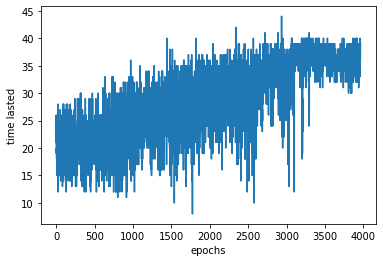

In [21]:
import matplotlib.pyplot as plt

plt.figure()
xs = [i for i in range(1, 3964)]
plt.plot(xs, time_lasted)
plt.xlabel("epochs")
plt.ylabel("time lasted")
plt.show()

In [22]:
PATH="./model_with_swap_1"
torch.save(agent.policy_net.state_dict(), PATH)